# Setup
Importing Data, dropping unneccessary columns to see the structure of the data better 

In [453]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error



import ast
import seaborn as sns
from plotnine import *

In [454]:
# Import the prewritten helper functions
# We are only using the color palette in this notebook
from py_helper_functions import *

In [455]:
listings = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Data-Analysis-3/main/assignment-2/data/listings.csv')

In [456]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23185 entries, 0 to 23184
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            23185 non-null  int64  
 1   listing_url                                   23185 non-null  object 
 2   scrape_id                                     23185 non-null  int64  
 3   last_scraped                                  23185 non-null  object 
 4   source                                        23185 non-null  object 
 5   name                                          23185 non-null  object 
 6   description                                   22822 non-null  object 
 7   neighborhood_overview                         13256 non-null  object 
 8   picture_url                                   23185 non-null  object 
 9   host_id                                       23185 non-null 

In [457]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [458]:
# drop some unnecessary columns
# these are mainly NAs,empty lists, urls, ids, or simpy variables that are just non relevant for the analysis
drop = ['listing_url','scrape_id','last_scraped','source','name','description','neighborhood_overview','picture_url','host_id','host_url',
                                  'host_name','host_since','host_location','host_about','host_thumbnail_url','host_picture_url','calendar_updated','calendar_last_scraped',
                                  'first_review','last_review','neighbourhood_group_cleansed','bathrooms','license','host_verifications','host_neighbourhood','has_availability',
                                  'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                                  'minimum_nights_avg_ntm','maximum_nights_avg_ntm','availability_30','availability_60','availability_90',"host_response_time",
                                  "host_response_rate","host_acceptance_rate","host_is_superhost","host_listings_count","host_total_listings_count",]

listings = listings.drop(columns=drop)

In [459]:
listings.shape

(23185, 33)

# Cleaning the Data

## Cleaning numeric columns

In [460]:
# format binary variables
for binary in [
    "host_has_profile_pic",
    "host_identity_verified",
]:
    listings[binary] = listings[binary].map({"t": 1, "f": 0})


# formatting price column
listings['price'] = pd.to_numeric(listings['price'].replace('[\$,]', '', regex=True), errors='coerce')

# drop where price is missing
listings = listings.dropna(subset=['price'])

In [461]:
# look at these variables
listings[["host_has_profile_pic","host_identity_verified","instant_bookable","price"]].describe()

,host_has_profile_pic,host_identity_verified,price
count,23183.000000,23183.000000,23185.000000
mean,0.983307,0.896174,231.167134
std,0.128122,0.305041,1334.007349
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,95.000000
50%,1.000000,1.000000,149.000000
75%,1.000000,1.000000,226.000000
max,1.000000,1.000000,104983.000000


## Cleaning categorical/string columns

In [462]:
# Rename room type because it is too long
listings["room_type"] = listings["room_type"].map(
    {"Entire home/apt": "Entire",
        "Private room": "Private",
        "Shared room": "Shared"})

# check the distribution of room types
listings['room_type'].value_counts(dropna=False)

Entire     16887
Private     5932
Shared       277
NaN           89
Name: room_type, dtype: int64

In [463]:
# convert bathrooms_text to float
# def function to clean the bathroom text, split and space and set to int, if not possible set to 1
def clean_bathroom(text):
    try:
        return float(text.split(" ")[0])
    except:
        return text == 1 # the only missing was shared bath and Half-bath, which we can set to be 1

# apply function to the column
listings["bathrooms"] = listings["bathrooms_text"].apply(clean_bathroom)
listings.drop(columns="bathrooms_text", inplace=True)

# check the values
listings["bathrooms"].value_counts(dropna=False)

1.0     15054
2.0      4553
1.5      1557
2.5       937
3.0       436
3.5       238
0.0       159
4.0       121
4.5        28
5.0        21
8.0        21
5.5        20
7.5        13
6.0        10
8.5         6
11.0        3
6.5         3
7.0         2
9.5         2
9.0         1
Name: bathrooms, dtype: int64

Cleaning Amenities:

In [464]:
# This block is responsible for exporting a CSV file with unique amenities, so I can group them into categories  in Excel and create dummies for them later
# create lists instead of srings for amenities
listings["amenities"] = listings["amenities"].astype(str).str.strip("[]").str.replace('"', "").str.split(",")

# Get sorted unique values of "amenities" column
#sorted_unique_amenities = sorted(listings["amenities"].explode().unique())

# Create a DataFrame from the sorted unique values
#df_unique_amenities = pd.DataFrame(sorted_unique_amenities, columns=["amenities"])

# Save DataFrame to a CSV file
#df_unique_amenities.to_csv("unique_amenities.csv", index=False)

In [465]:
# after excel work import file from github
amenities_mapping = pd.read_csv("https://raw.githubusercontent.com/szilvasipeter2000/Data-Analysis-3/main/assignment-2/data/amenities_mapping.csv",delimiter=";")

In [466]:
amenities_mapping.shape

(3946, 2)

In [467]:
amenities_mapping.head(10)

,amenities,new
0,Aveda conditioner,soap_shampoo
1,electric electric stove,stove
2,micro,microwave
3,Natural body soap,soap_shampoo
4,Normal shampoo,soap_shampoo
5,Samsung refrigerator,fridge
6,& AUD$2.50 d\u014dTERRA Body Moisturisers bod...,soap_shampoo
7,& Sukin shampoo,soap_shampoo
8,. conditioner,soap_shampoo
9,. shampoo,soap_shampoo


In [468]:
# create a dictionary from the amenities_mapping DataFrame
replacement_dict = dict(zip(amenities_mapping["amenities"], amenities_mapping["new"]))

# replace the values in the "amenities" column with the new values
listings['amenities_cleaned'] = listings['amenities'].apply(lambda x: [replacement_dict[val] if val in replacement_dict else val for val in x])

print(sorted(listings["amenities_cleaned"].explode().unique()))

['', 'airconditioning', 'alarm', 'backyard', 'balcony', 'bathroom_equipment', 'bathtub', 'bbq', 'beach', 'bedlinens', 'bike', 'boat', 'books', 'breakfast', 'chair', 'cleaning', 'cleaning_equipment', 'clothing_storage', 'coffee', 'dryer', 'elevator', 'exercise_equipment', 'fireextinguisher', 'fireplace', 'firstaidkit', 'freeparking', 'fridge', 'fruit', 'gameconsole', 'games', 'garage', 'gym', 'heating', 'host_greet', 'hottub', 'hotwater', 'iron', 'kidfriendly', 'kitchen_equipment', 'lakeside', 'lock', 'longterm', 'luxury_accessories', 'microwave', 'movies', 'other', 'outdoors', 'oven', 'paidparking', 'petfriendly', 'piano', 'pool', 'private', 'resortaccess', 'rooftop', 'sauna', 'security', 'selfcheckin', 'shades', 'skiing', 'smoking', 'soap_shampoo', 'soundsystem', 'stove', 'table', 'tennis', 'transfer', 'tv', 'view', 'washingmachine', 'wifi', 'workspace']


In [469]:
# create dummies for amenities
unique_amenities = set()
for amenities_list in listings['amenities_cleaned']:
    unique_amenities.update(amenities_list)

for amenity in unique_amenities:
    listings['d_' + amenity] = listings['amenities_cleaned'].apply(lambda x: 1 if amenity in x else 0)

In [470]:
# we can we have a lot more variables
listings.shape

(23185, 106)

In [471]:
# peak at the amenities
dummy_desc = listings[listings.columns[listings.columns.str.startswith("d_")]].describe()
dummy_desc

,d_freeparking,d_,d_airconditioning,d_kitchen_equipment,d_alarm,d_microwave,d_other,d_garage,d_smoking,d_cleaning,...,d_dryer,d_fruit,d_balcony,d_soundsystem,d_firstaidkit,d_breakfast,d_rooftop,d_resortaccess,d_wifi,d_workspace
count,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,...,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000
mean,0.663662,0.001941,0.863705,0.973992,0.937934,0.610308,0.876515,0.022515,0.073927,0.080138,...,0.824973,0.000043,0.429200,0.067457,0.360535,0.090878,0.003882,0.016304,0.931421,0.401423
std,0.472466,0.044014,0.343109,0.159163,0.241281,0.487691,0.329000,0.148353,0.261658,0.271513,...,0.379998,0.006567,0.494973,0.250818,0.480166,0.287441,0.062185,0.126643,0.252742,0.490197
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Feature Engineering

In [472]:
# where do we have missing variables?
to_filter = listings.isna().sum()
to_filter[to_filter > 0]

host_has_profile_pic              2
host_identity_verified            2
neighbourhood                  9928
room_type                        89
bedrooms                       6297
beds                            183
review_scores_rating           4510
review_scores_accuracy         4756
review_scores_cleanliness      4752
review_scores_checkin          4758
review_scores_communication    4753
review_scores_location         4758
review_scores_value            4758
reviews_per_month              4510
dtype: int64

In [473]:
# first create flags for missing variables, then input with median.

listings = listings.assign(
    # flag for beds
    flag_beds=np.multiply(listings.beds.isna(), 1),
    beds=listings.beds.fillna(np.median(listings.beds.dropna())),
    # flag for bathrooms
    flag_bathrooms=np.multiply(listings.bathrooms.isna(), 1),
    bathrooms=listings.bathrooms.fillna(np.median(listings.bathrooms.dropna())),
    # flag for cleaniness reviews
    flag_review_scores_cleanliness=np.multiply(listings.review_scores_cleanliness.isna(), 1),
    review_scores_cleanliness=listings.review_scores_cleanliness.fillna(
        np.median(listings.review_scores_cleanliness.dropna())),
    # flag for review score
    flag_review_scores_rating=np.multiply(listings.review_scores_rating.isna(), 1),
    review_scores_rating=listings.review_scores_rating.fillna(
        np.median(listings.review_scores_rating.dropna())),
    # flag for reviews per month
    flag_reviews_per_month=np.multiply(listings.reviews_per_month.isna(), 1),
    reviews_per_month=listings.reviews_per_month.fillna(
        np.median(listings.reviews_per_month.dropna())),
    # flag for number of reviews
    flag_number_of_reviews=np.multiply(listings.number_of_reviews.isna(), 1),
    number_of_reviews=listings.number_of_reviews.fillna(
        np.median(listings.number_of_reviews.dropna())),
    # flag for checkin reviews
    flag_review_scores_checkin=np.multiply(listings.review_scores_checkin.isna(), 1),
    review_scores_checkin=listings.review_scores_checkin.fillna(
        np.median(listings.review_scores_checkin.dropna())),
    # flag for communication reviews
    flag_review_scores_communication=np.multiply(listings.review_scores_communication.isna(), 1),
    review_scores_communication=listings.review_scores_communication.fillna(
        np.median(listings.review_scores_communication.dropna())),
    # flag for location reviews
    flag_review_scores_location=np.multiply(listings.review_scores_location.isna(), 1),
    review_scores_location=listings.review_scores_location.fillna(
        np.median(listings.review_scores_location.dropna())),
    # flag for value reviews
    flag_review_scores_value=np.multiply(listings.review_scores_value.isna(), 1),
    review_scores_value=listings.review_scores_value.fillna(
        np.median(listings.review_scores_value.dropna())),
    )

In [474]:
# filter based on property type, also rename them to a more general category
# define set of good property types, that fit the business needs
propertytypes = ["Entire rental unit",
                 "Private room in rental unit",
                 "Entire home",
                 "Entire condo",
                 "Private room in home",
                 "Apartment",
                 "House",
                 "Townhouse",
                 "Shared room in rental unit"]

# keep if property type is in the set
listings = listings.loc[lambda x: x["property_type"].isin(propertytypes)]

# rename to Rental unit or House
listings['property_type'] = listings['property_type'].apply(lambda x: 'Rental Unit' if "rental unit" in x else 'House')

In [475]:
# bedrooms
listings.bedrooms.value_counts(dropna=False)

2.0     5718
1.0     5027
NaN     4963
3.0     2053
4.0      872
5.0      243
6.0       76
7.0       21
10.0       4
9.0        3
11.0       3
8.0        3
14.0       3
Name: bedrooms, dtype: int64

In [476]:
before = listings.shape[0]
listings = listings.dropna(subset=['bedrooms'])
after = listings.shape[0]
print(f"Dropped {before-after} rows due to missing bedrooms")

Dropped 4963 rows due to missing bedrooms


In [477]:
## drop huge number of bathrooms
before = listings.shape[0]
listings=listings.loc[listings.bathrooms < 8]
after = listings.shape[0]
print(f"Dropped {before - after} rows with bathrooms < 8")

Dropped 18 rows with bathrooms < 8


In [478]:
listings.bathrooms.value_counts(dropna=False).reset_index(drop = True)

0     8469
1     3682
2      677
3      624
4      291
5      165
6       44
7       22
8        9
9        8
10       7
11       7
12       1
13       1
14       1
Name: bathrooms, dtype: int64

In [479]:
# Pool bathrooms with 0,1,2,10 bathrooms
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 7)], closed="left")
f_bath = pd.cut(listings["bathrooms"].to_list(), bins, labels=["0", "1", "2"])
f_bath.categories = [0, 1, 2]
listings["bathrooms"] = f_bath

f_bath.value_counts(dropna=False)

0         7
1      9146
2      4853
NaN       2
dtype: int64

In [480]:
listings["room_type"].value_counts()

Entire     13883
Private      125
Name: room_type, dtype: int64

In [481]:
# Pool and categorize the number of minimum nights: 1,2,3, 3+

bins = pd.IntervalIndex.from_tuples(
    [(1, 2), (2, 3), (3, max(listings.minimum_nights))], closed="left"
)
f_min_n = pd.cut(listings["minimum_nights"].to_list(), bins, labels=["1", "2", "3"])
f_min_n.categories = [1, 2, 3]
listings["minimum_nights"] = f_min_n
listings["minimum_nights"].value_counts(dropna=False)

3      5103
2      5001
1      3903
NaN       1
Name: minimum_nights, dtype: int64

In [482]:
# Pool num of reviews to 3 categories: none, 1-51 and >51

bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (1, 51), (51, max(listings.number_of_reviews))], closed="left"
)
fnor = pd.cut(listings["number_of_reviews"].to_list(), bins, labels=["0", "1", "2"])
fnor.categories = [0, 1, 2]
listings["number_of_reviews"] = fnor
listings["number_of_reviews"].value_counts(dropna=False)

1      8990
2      2647
0      2370
NaN       1
Name: number_of_reviews, dtype: int64

In [483]:
listings['availability_365'].value_counts().sort_index()

0      3331
1        39
2        68
3        36
4        20
       ... 
361      43
362      53
363      60
364      63
365     161
Name: availability_365, Length: 366, dtype: int64

In [484]:
# Pool availability 365 to 4 categories: 1-51,51-151,151-251, >251

bins = pd.IntervalIndex.from_tuples(
    [(0, 51), (51, 151), (151, 251), (251, max(listings.availability_365))], closed="left"
)

fnor = pd.cut(listings["availability_365"].to_list(), bins, labels=["0", "1", "2", "3"])
fnor.categories = [0, 1, 2, 3]
listings["availability_365"] = fnor

listings["availability_365"].value_counts(dropna=False)

0      4673
1      3576
3      3506
2      2092
NaN     161
Name: availability_365, dtype: int64

In [485]:
listings.bedrooms.value_counts(dropna=False)

2.0     5718
1.0     5015
3.0     2053
4.0      872
5.0      243
6.0       76
7.0       21
9.0        3
8.0        3
11.0       2
14.0       1
10.0       1
Name: bedrooms, dtype: int64

In [486]:
listings.T

,1,2,4,5,6,9,10,11,12,13,...,23173,23174,23176,23177,23178,23179,23180,23181,23182,23183
id,12936,38271,43429,1181117,1188388,1192689,44082,1201338,1210073,1233439,...,971385848818575605,969280954896268255,971570547679229207,969308498306934752,971588505523400983,971599030604344292,971604763527045723,969314524632337156,971613881418926837,971616602219608699
host_has_profile_pic,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
host_identity_verified,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
neighbourhood,"St Kilda, Victoria, Australia","Berwick, Victoria, Australia","Oakleigh East, Victoria, Australia","Ripponlea, Victoria, Australia","Port Melbourne, Victoria, Australia","St Kilda, Victoria, Australia","Frankston, Victoria, Australia","South Melbourne, Victoria, Australia",NaN,"Melbourne, Victoria, Australia",...,NaN,"Southbank, Victoria, Australia",NaN,"South Yarra, Victoria, Australia",NaN,"Melbourne, Victoria, Australia",NaN,NaN,NaN,NaN
neighbourhood_cleansed,Port Phillip,Casey,Monash,Port Phillip,Port Phillip,Port Phillip,Frankston,Port Phillip,Darebin,Stonnington,...,Melbourne,Melbourne,Melbourne,Stonnington,Melbourne,Port Phillip,Melbourne,Melbourne,Yarra,Whitehorse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
flag_number_of_reviews,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
flag_review_scores_checkin,0,0,0,1,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
flag_review_scores_communication,0,0,0,1,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
flag_review_scores_location,0,0,0,1,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [487]:
# scrollable value counts for all variables
for column in listings.columns:
    print(listings[column].value_counts(dropna=False))
    print(##################################################################
    )

12936                 1
766817912048480711    1
768605076805768701    1
768689686030733073    1
771456254109537745    1
                     ..
37865372              1
37539101              1
37539846              1
38006276              1
971616602219608699    1
Name: id, Length: 14008, dtype: int64

1.0    13769
0.0      239
Name: host_has_profile_pic, dtype: int64

1.0    12920
0.0     1088
Name: host_identity_verified, dtype: int64

NaN                                           5710
Melbourne, Victoria, Australia                1555
Southbank, Victoria, Australia                 695
South Yarra, Victoria, Australia               401
Carlton, Victoria, Australia                   299
                                              ... 
St kilda, Victoria, Australia                    1
Kooyong, Victoria, Australia                     1
Williams Landing, Australia                      1
Brunswick / Melbourne, Victoria, Australia       1
Seville, Victoria, Australia                     

# Exploratory Data Analysis

In [488]:
listings.shape

(14008, 116)

In [489]:
listings['price'].describe(percentiles=[0.25, 0.5, 0.75,0.8,0.85, 0.9, 0.95, 0.99])

count    14008.000000
mean       255.652199
std        965.091773
min         14.000000
25%        130.000000
50%        170.000000
75%        256.000000
80%        293.000000
85%        338.000000
90%        409.000000
95%        600.000000
99%       1248.530000
max      99999.000000
Name: price, dtype: float64

In [490]:
## drop unreasonable prices
before = listings.shape[0]
listings = listings[listings['price'] <= 400]
after = listings.shape[0]
print(f"Dropped {before - after} rows with price <= 400")

Dropped 1439 rows with price <= 400


Text(0, 0.5, 'Number of listings')

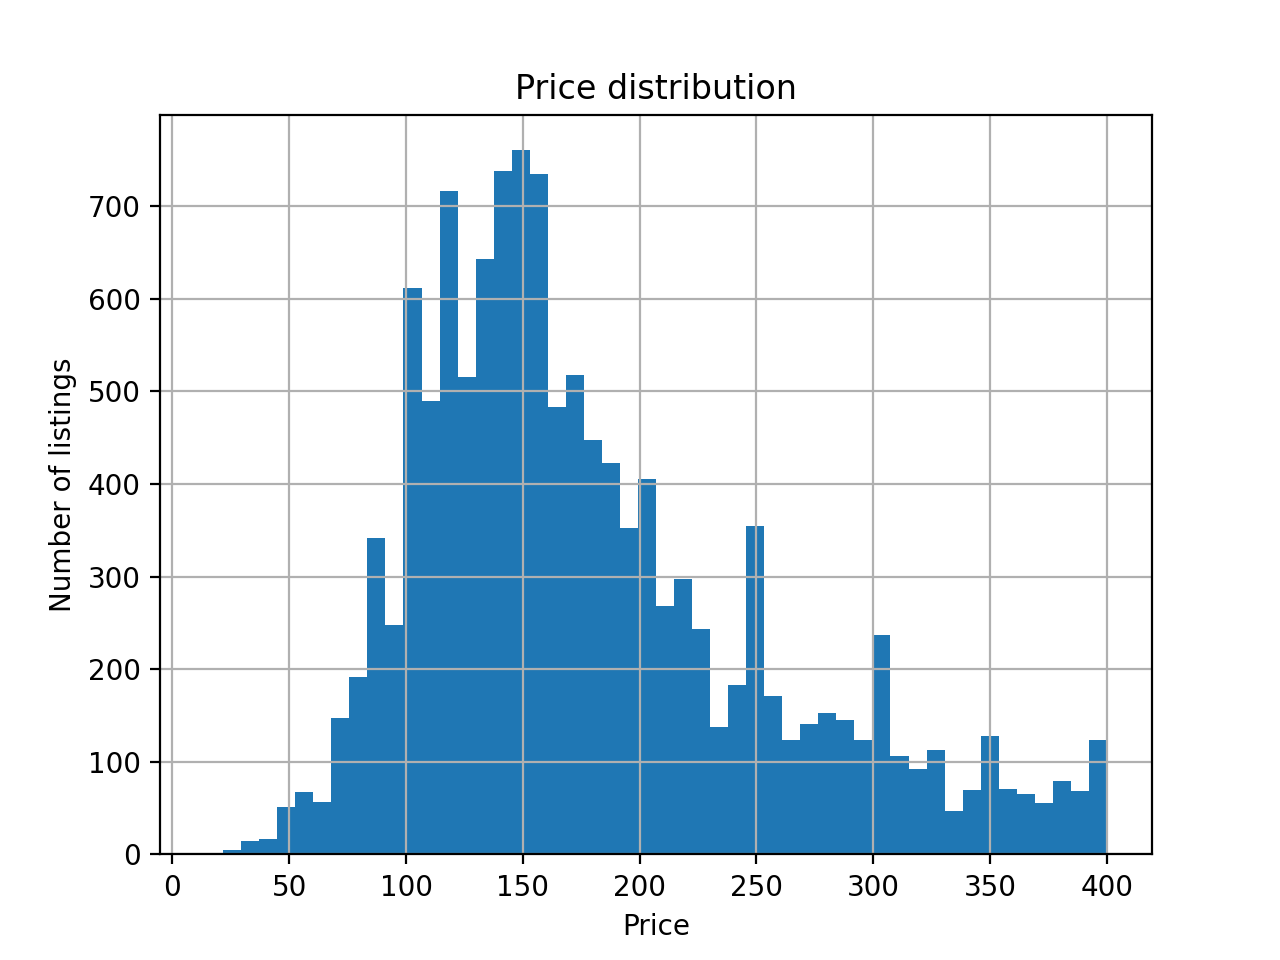

In [491]:
listings['price'].hist(bins = 50)
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Number of listings')

Since our price distribution is skewed to the right, our Models going to have quite high RMSE values. If we were to filter for only lower valus of price, our RMSEs would decrase.

In [492]:
## drop huge number of accomodates
before = listings.shape[0]
listings=listings.loc[listings.accommodates < 7]
after = listings.shape[0]
print(f"Dropped {before - after} rows with accomodates < 7")

Dropped 1153 rows with accomodates < 7


In [493]:
before = listings.shape[0]
listings["beds"].value_counts(dropna=False)
listings = listings.loc[listings.beds > 0]
after = listings.shape[0]
print(f"Dropped {before - after} rows with beds > 0")

Dropped 0 rows with beds > 0


In [494]:
before = listings.shape[0]
listings = listings.dropna(subset = ["availability_365","minimum_nights","number_of_reviews", "bathrooms"])
after = listings.shape[0]
print(f"Dropped {before - after} rows with missing values")

Dropped 91 rows with missing values


In [495]:
# we still have enough data to work with
listings.shape

(11325, 116)

In [496]:
listings.groupby(["accommodates"]).agg(mean_price=("price", np.mean))

,mean_price
accommodates,
1,99.488636
2,141.859182
3,147.666667
4,179.564145
5,197.394144
6,227.596469


<Axes: xlabel='accommodates'>

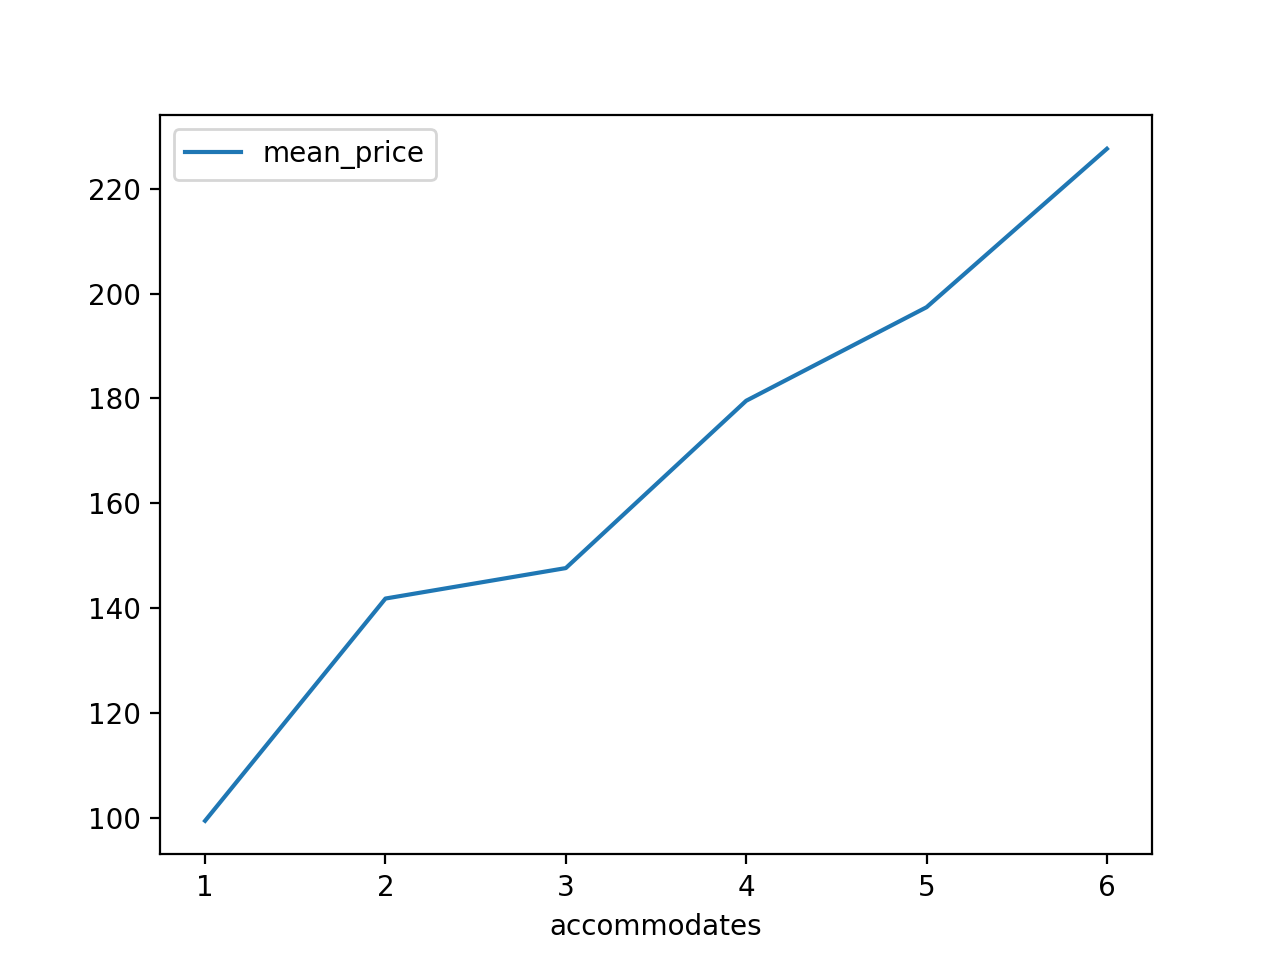

In [497]:
listings.groupby(["accommodates"]).agg(mean_price=("price", np.mean)).plot()

In [498]:
#How is the average price changing in my district by `property_type`, `room_type`?
listings.groupby(["property_type", "room_type"]).agg(mean_price=("price", np.mean))

mean_price
property_type room_type            
House         Entire     201.663385
              Private     78.900000
Rental Unit   Entire     164.568097
              Private    103.083333

<Axes: xlabel='availability_365'>

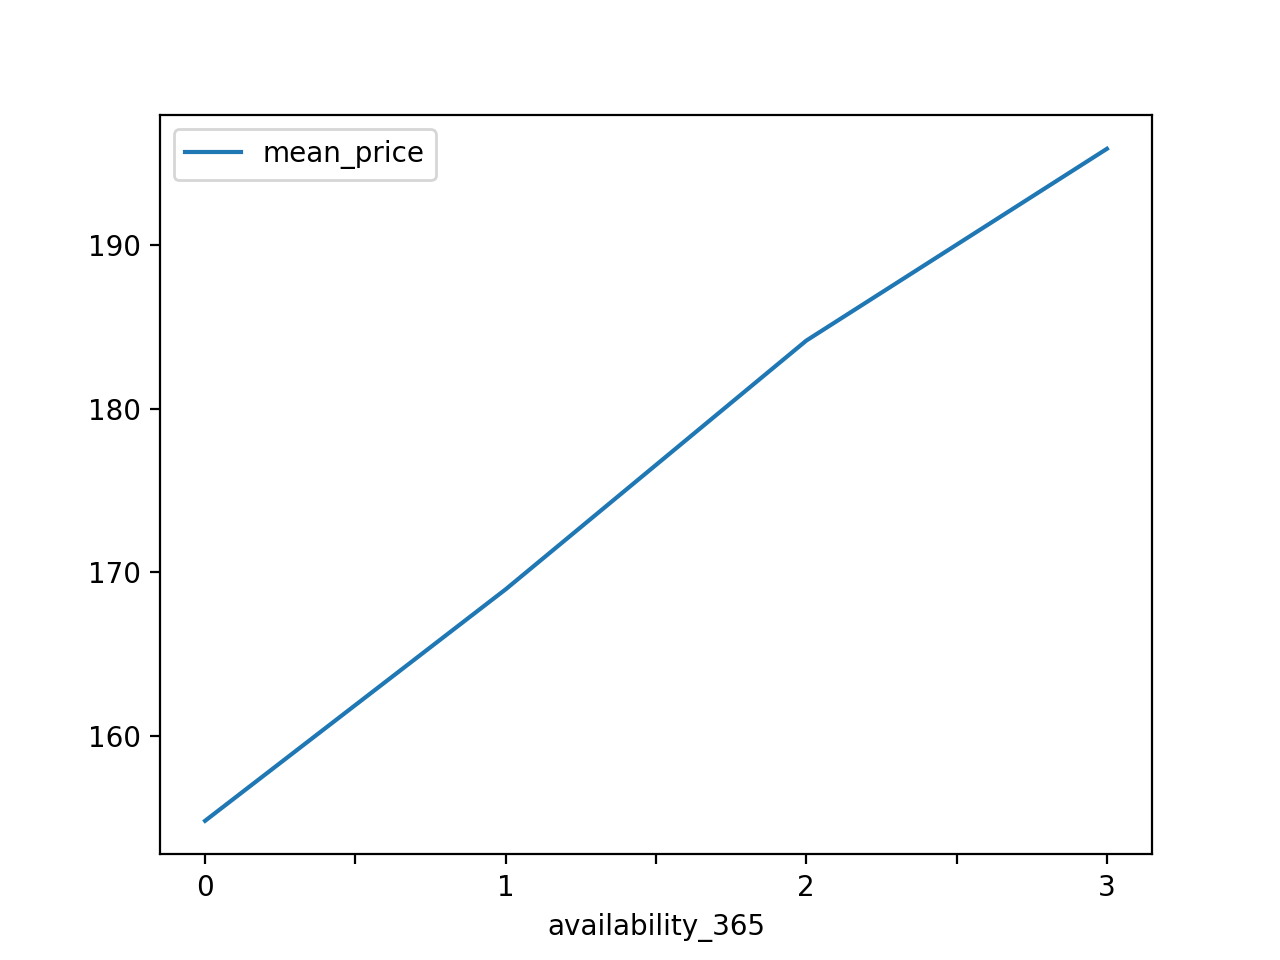

In [499]:
#What is the correlation between availability of the AirBnb and its Price?
listings.groupby("availability_365").agg(mean_price=("price", np.mean)).plot()

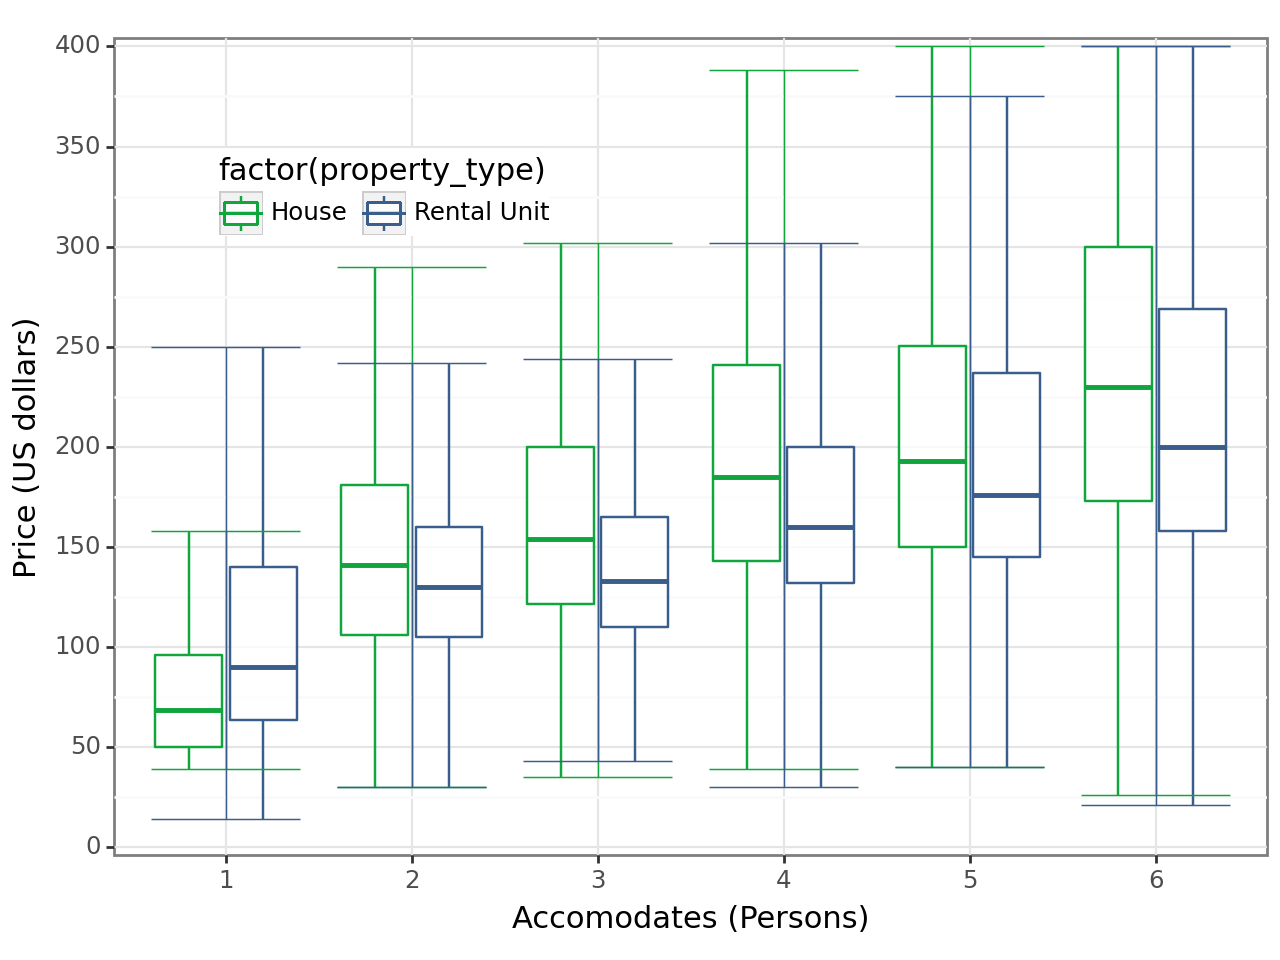

<Figure Size: (640 x 480)>

In [500]:
(
    ggplot(
        listings,
        aes(
            x="factor(accommodates)",
            y="price",
            # fill="factor(f_property_type)",
            color="factor(property_type)",
        ),
    )
    + geom_boxplot(alpha=0.8, na_rm=True, outlier_shape="", width=0.8, stat="boxplot")
    + stat_boxplot(geom="errorbar", width=0.8, size=0.3, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_fill_manual(name="", values=(color[1], color[0]))
    + labs(x="Accomodates (Persons)", y="Price (US dollars)")
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
    + theme(legend_position=(0.3, 0.8))
)

# Variable Selection

In [501]:
basic_lev = (
    "accommodates",
    "beds",
    "flag_beds",
    "property_type",
    "room_type",
    "bedrooms")

basic_add = ("bathrooms",
             "flag_bathrooms",
             "neighbourhood_cleansed",
             "availability_365",
             "minimum_nights")

reviews = ("number_of_reviews",
           "flag_number_of_reviews",
           "reviews_per_month",
           "flag_reviews_per_month",
           "review_scores_rating",
           "flag_review_scores_rating")

more_reviews = ("review_scores_cleanliness",
                "flag_review_scores_cleanliness",
                "review_scores_checkin",
                "flag_review_scores_checkin",
                "review_scores_communication",
                "flag_review_scores_communication",
                "review_scores_location",
                "flag_review_scores_location",
                "review_scores_value",
                "flag_review_scores_value")

amenity_columns = tuple([col for col in listings.columns if col.startswith("d_")])

In [502]:
X1 = "room_type:property_type"
X2 = (" + d_petfriendly:room_type", "a_bathtub:room_type")
X3 = "(property_type + beds + bedrooms + room_type + bathrooms):(" + "+".join(amenity_columns) + ")"

modellev1 = "~ accommodates"
modellev2 = "~" + "+".join(basic_lev)
modellev3 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add)
modellev4 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)
modellev5 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1
modellev6 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1+"+"+"+".join(X2)
modellev7 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1+"+"+"+".join(X2)+ "+" + "+".join(amenity_columns)
modellev8 = ("~"+ "+".join(basic_lev)+ "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+"+ "+".join(more_reviews)+ "+"+ X1+ "+"+ "+".join(amenity_columns)+ "+"+ X3)


# LASSO Model for Interaction Selection:
Lasso is mainly used for feature selection, as it shrinks the coefficients of less important features to exactly 0.
This is useful for feature selection, as it can be used to remove less important features from the model.
Will also include lots of interactions so in the end we can see which interactions are important.

In [503]:
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import datetime

In [504]:
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
smp_size = round(0.2 * listings.shape[0])-1
y, X = patsy.dmatrices("price" + modellev8, listings) # use the most complex model

In [505]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=smp_size, random_state=10
)

lambdas = [i/100 for i in range(5, 100,5)]

train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))

pred_num = X.shape[1]
coeff_a = np.zeros((len(lambdas), pred_num))

In [506]:
for ind, i in enumerate(lambdas):
    print(f"Run: {str(ind).rjust(2)}, lambda: {i:.2f}, start: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    reg = Lasso(alpha = i, random_state= 20240115)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=cv, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

Run:  0, lambda: 0.05, start: 2024-02-10 23:35:41
Run:  1, lambda: 0.10, start: 2024-02-10 23:36:59
Run:  2, lambda: 0.15, start: 2024-02-10 23:38:09
Run:  3, lambda: 0.20, start: 2024-02-10 23:39:23
Run:  4, lambda: 0.25, start: 2024-02-10 23:40:10
Run:  5, lambda: 0.30, start: 2024-02-10 23:40:45
Run:  6, lambda: 0.35, start: 2024-02-10 23:41:17
Run:  7, lambda: 0.40, start: 2024-02-10 23:41:51
Run:  8, lambda: 0.45, start: 2024-02-10 23:42:24
Run:  9, lambda: 0.50, start: 2024-02-10 23:42:58
Run: 10, lambda: 0.55, start: 2024-02-10 23:43:34
Run: 11, lambda: 0.60, start: 2024-02-10 23:44:22
Run: 12, lambda: 0.65, start: 2024-02-10 23:45:11
Run: 13, lambda: 0.70, start: 2024-02-10 23:46:05
Run: 14, lambda: 0.75, start: 2024-02-10 23:46:51
Run: 15, lambda: 0.80, start: 2024-02-10 23:47:33
Run: 16, lambda: 0.85, start: 2024-02-10 23:48:20
Run: 17, lambda: 0.90, start: 2024-02-10 23:49:04
Run: 18, lambda: 0.95, start: 2024-02-10 23:49:56


In [507]:
r_squared_data = (
    pd.DataFrame(
        {
            "$R^2$ Test set": test_r_squared,
            "$R^2$ Training set": train_r_squared,
            "lambda": lambdas,
        }
    )
    .melt(id_vars=["lambda"])
)

In [508]:
r_squared_data["variable"] = r_squared_data["variable"].astype("category").cat.reorder_categories(
    ["$R^2$ Training set", "$R^2$ Test set"]
)

In [509]:
r_squared_data

,lambda,variable,value
0,0.05,$R^2$ Test set,0.366757
1,0.10,$R^2$ Test set,0.375812
2,0.15,$R^2$ Test set,0.378581
3,0.20,$R^2$ Test set,0.380567
4,0.25,$R^2$ Test set,0.382280
5,0.30,$R^2$ Test set,0.382666
6,0.35,$R^2$ Test set,0.382698
7,0.40,$R^2$ Test set,0.382500
8,0.45,$R^2$ Test set,0.382372
9,0.50,$R^2$ Test set,0.382056


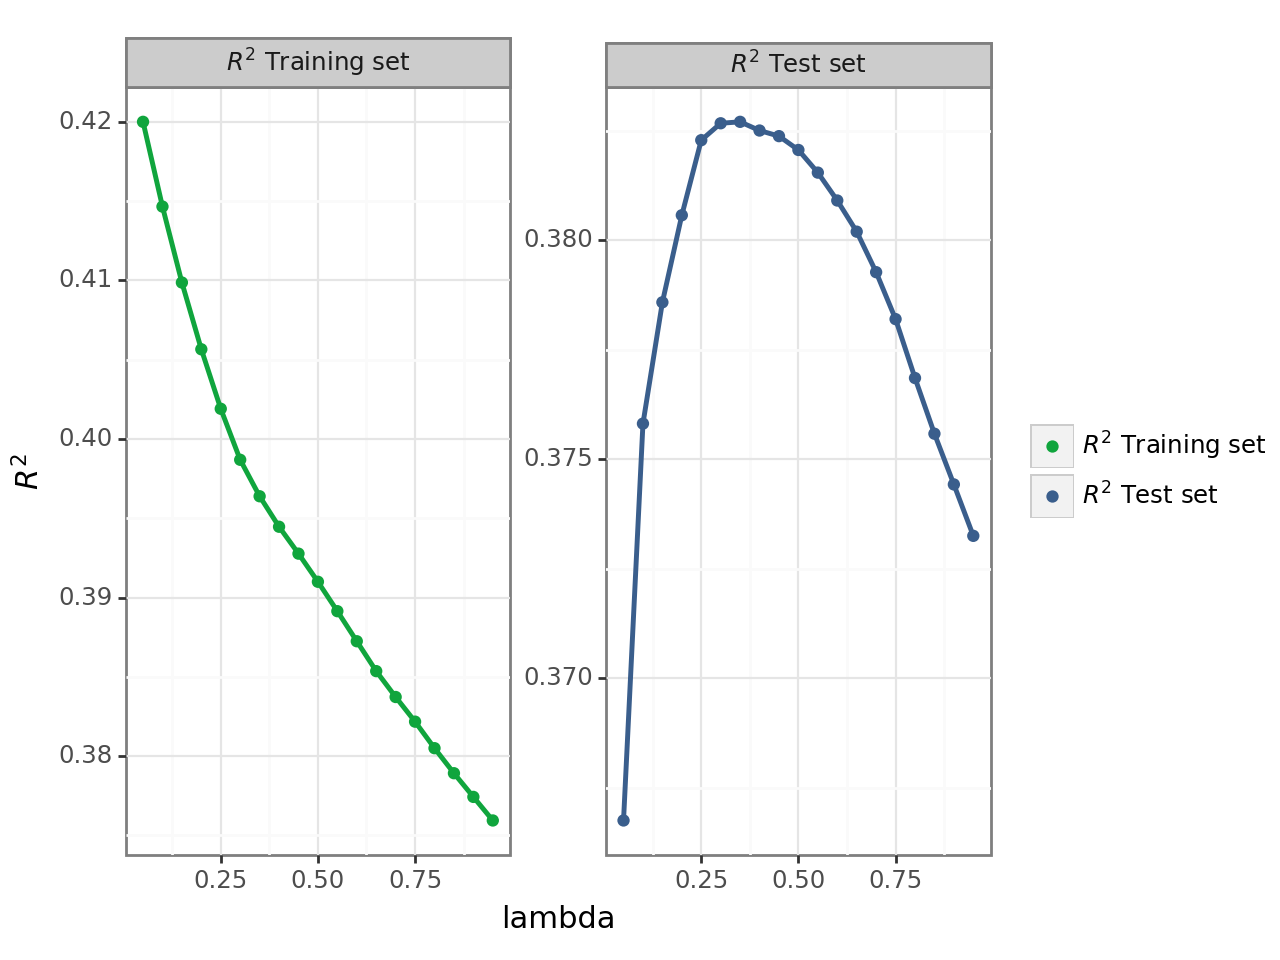

<Figure Size: (640 x 480)>

In [510]:
(
    ggplot(r_squared_data, aes(x="lambda", y="value", color="variable"))
    + geom_point()
    + geom_line(size=1, show_legend=False, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_y_continuous(name="$R^2$")
    + facet_wrap("variable", scales="free")
    + theme_bw()
    + theme(subplots_adjust={"wspace": 0.25},legend_title=element_blank())
)

In [511]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    38.269845
lambda        0.350000
Name: 6, dtype: float64

In [512]:
reg_best = Lasso(alpha = df_lam.loc[df_lam['R_squared'].idxmax()]['lambda'])
reg_best.fit(X_train, y_train)

Lasso(alpha=0.35)

In [513]:
coefficients = reg_best.coef_[reg_best.coef_>0]

# write the coefficients to a file so later we don't have to rerun the model
with open('coefficients.txt', 'w') as file:
    for feature, coefficient in zip(modellev8.split('+'), coefficients):
        file.write(f"{feature.strip()} = {coefficient}\n")

# print out the results
for feature, coefficient in zip(modellev8.split('+'), coefficients):
    print(f"{feature.strip()} = {coefficient}")


~accommodates = 1.145767908324589
beds = 0.11623357672717778
flag_beds = 0.52236409087918
property_type = 2.643385807534356
room_type = 0.4036939275501617
bedrooms = 1.8345219085753457
bathrooms = 0.46634481573279263
flag_bathrooms = 3.6620870475841585
neighbourhood_cleansed = 5.723634000599311
availability_365 = 3.8814500855961085
minimum_nights = 5.7710378914613205
number_of_reviews = 12.237616989413159
flag_number_of_reviews = 0.6326139555348573
reviews_per_month = 1.090366937591324
flag_reviews_per_month = 8.553221585216795
review_scores_rating = 0.5296077899414927
flag_review_scores_rating = 2.2371796812296
review_scores_cleanliness = 6.9213671604812
flag_review_scores_cleanliness = 0.1918351107345082
review_scores_checkin = 0.4261447042013103
flag_review_scores_checkin = 1.6755025213074664
review_scores_communication = 2.646695017188438
flag_review_scores_communication = 0.007070112691915292
review_scores_location = 1.6975609916271708
flag_review_scores_location = 0.1725906095223

In [514]:
# good interactions: room_type:property_type

## Lasso using GridSearchCV
now we already now the best interactions.

In [515]:
data_work,data_holdout=train_test_split(listings, test_size=smp_size)

In [516]:
X1 = "room_type:property_type"

modellev1 = "~ accommodates"
modellev2 = "~" + "+".join(basic_lev)
modellev3 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add)
modellev4 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)
modellev5 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1
modellev6 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1+ "+" + "+".join(amenity_columns)

In [517]:
y,  X = patsy.dmatrices('price'+ modellev6, listings)

In [518]:
# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv=cv)
# perform the search
results = search.fit(X, y)

In [519]:
print(" RMSE: " + str(results.best_score_ * -1))

 RMSE: 56.7017035325528


In [520]:
best_lasso_model = results.best_estimator_
print(best_lasso_model)

Lasso(alpha=0.05)


In [521]:
model6_level = smf.ols('price'+modellev6, data=data_work).fit(cov_type='HC0')

In [522]:
# look at holdout RMSE
model6_level_work_predictions = pd.concat(
    [data_work["price"], model6_level.predict(data_work)],
    axis=1,
    keys=["price", "predicted"],
)

model6_level_work_predictions.tail()

,price,predicted
23178,80.0,100.022419
13690,159.0,159.364916
14889,80.0,138.327464
2350,130.0,151.268432
7095,100.0,150.857831


In [523]:
model6_level_work_predictions = model6_level_work_predictions[~model6_level_work_predictions.isna().any(axis=1)]
model6_level_work_rmse = rmse(model6_level_work_predictions["price"], model6_level_work_predictions["predicted"], axis=0)

In [524]:
model6_level_holdout_predictions = pd.concat(
    [data_holdout["price"], model6_level.predict(data_holdout)],
    axis=1,
    keys=["price", "predicted"],
)
model6_level_holdout_predictions = model6_level_holdout_predictions[~model6_level_holdout_predictions.isna().any(axis=1)]
model6_level_holdout_rmse = rmse(model6_level_holdout_predictions["price"], model6_level_holdout_predictions["predicted"], axis=0)
print(
    f"RMSE work:{round(model6_level_work_rmse,2)}",
    "\t",
    f"RMSE holdout:{model6_level_holdout_rmse:.2f}",
)

RMSE work:55.82 	 RMSE holdout:57.08


In [525]:
Ylev=data_holdout['price']
meanY=Ylev.mean()
sdY=Ylev.std()
meanY_m2SE = meanY -1.96 * sdY
meanY_p2SE = meanY + 1.96 * sdY
Y5p=Ylev.quantile(.05)
Y95p=Ylev.quantile(.95)

In [526]:
model6_level.get_prediction(data_holdout).summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,113.369040,12.202530,89.452521,137.285560,0.651215,226.086866
1,118.430429,4.197756,110.202979,126.657879,7.972296,228.888563
2,195.706954,13.857850,168.546067,222.867841,82.256427,309.157481
3,134.402366,5.115999,124.375191,144.429540,23.795619,245.009113
4,184.877852,5.068368,174.944034,194.811670,74.279529,295.476175
...,...,...,...,...,...,...
2259,160.189664,4.755410,150.869232,169.510096,49.644747,270.734581
2260,149.087384,15.407754,118.888741,179.286028,34.871508,263.303261
2261,228.341381,6.022831,216.536849,240.145914,117.559364,339.123398
2262,144.733652,5.779506,133.406029,156.061275,34.001437,255.465866


In [527]:
# Create data frame with the real and predicted values
data_diagnostic = model6_level.get_prediction(data_holdout).summary_frame(alpha=0.05)

df_ = pd.concat(
    [data_holdout["price"], model6_level.predict(data_holdout)],
    axis=1,
    keys=["price", "predicted"],
)

In [528]:
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
data_diagnostic["Ylev"] = df_["price"]

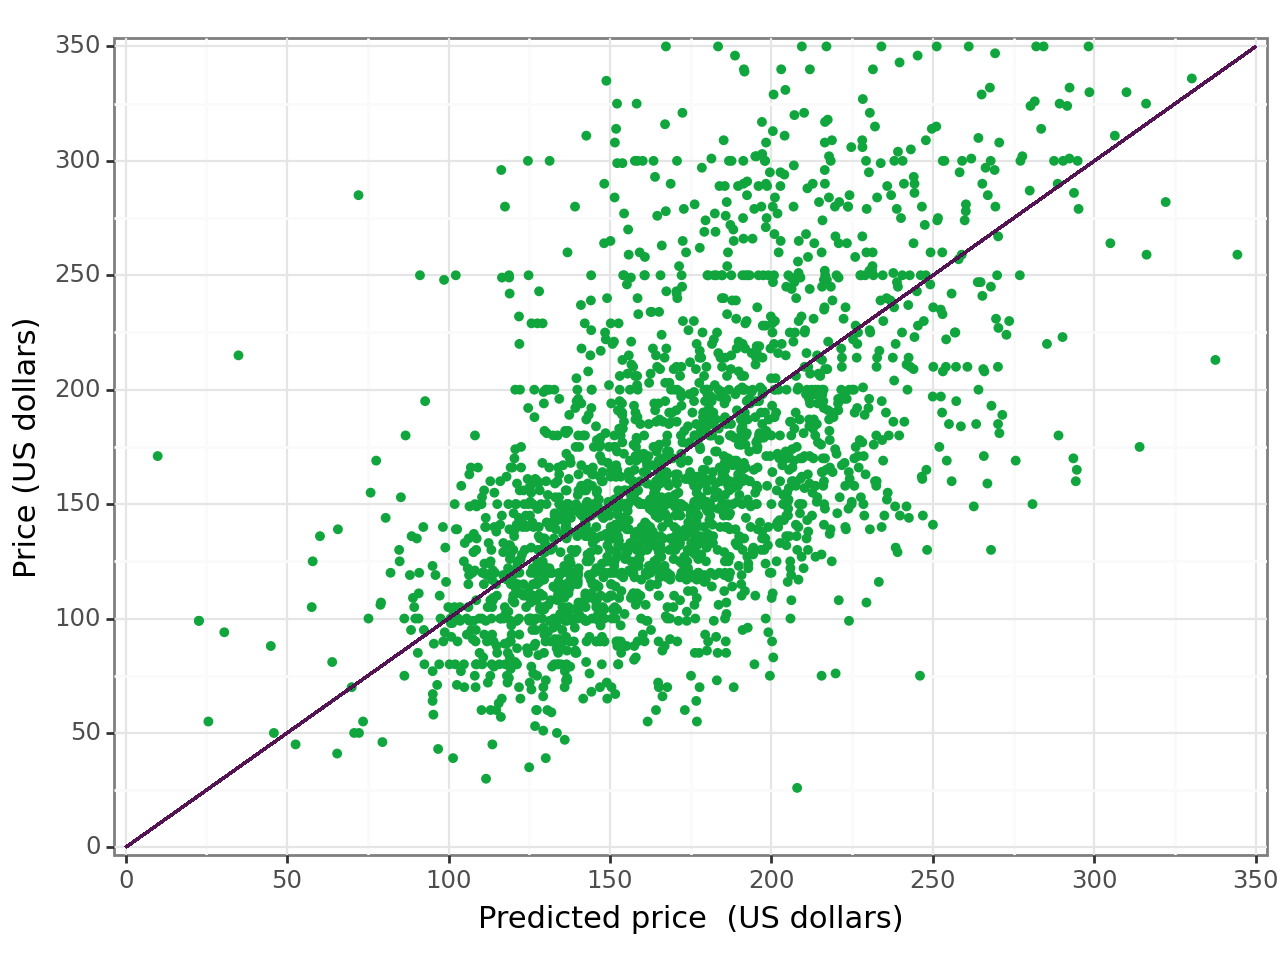

<Figure Size: (640 x 480)>

In [529]:
(
    ggplot(data=data_diagnostic)
    + geom_point(
        aes(y="Ylev", x="mean"),
        color=color[1],
        size=1,
        alpha=0.7,
        show_legend=False,
        na_rm=True,
    )
    + geom_segment(aes(x=0, y=0, xend=350, yend=350), size=0.5, color=color[2])
    + coord_cartesian(xlim=(0, 350), ylim=(0, 350))
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 350), breaks=seq(0, 350, by=50)
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 350), breaks=seq(0, 350, by=50)
    )
    + labs(y="Price (US dollars)", x="Predicted price  (US dollars)")
    + theme_bw()
)

# Interaction Visualization
This part visualizes those interactions that were found with Lasso

In [530]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab("Mean Price")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )

    return plot

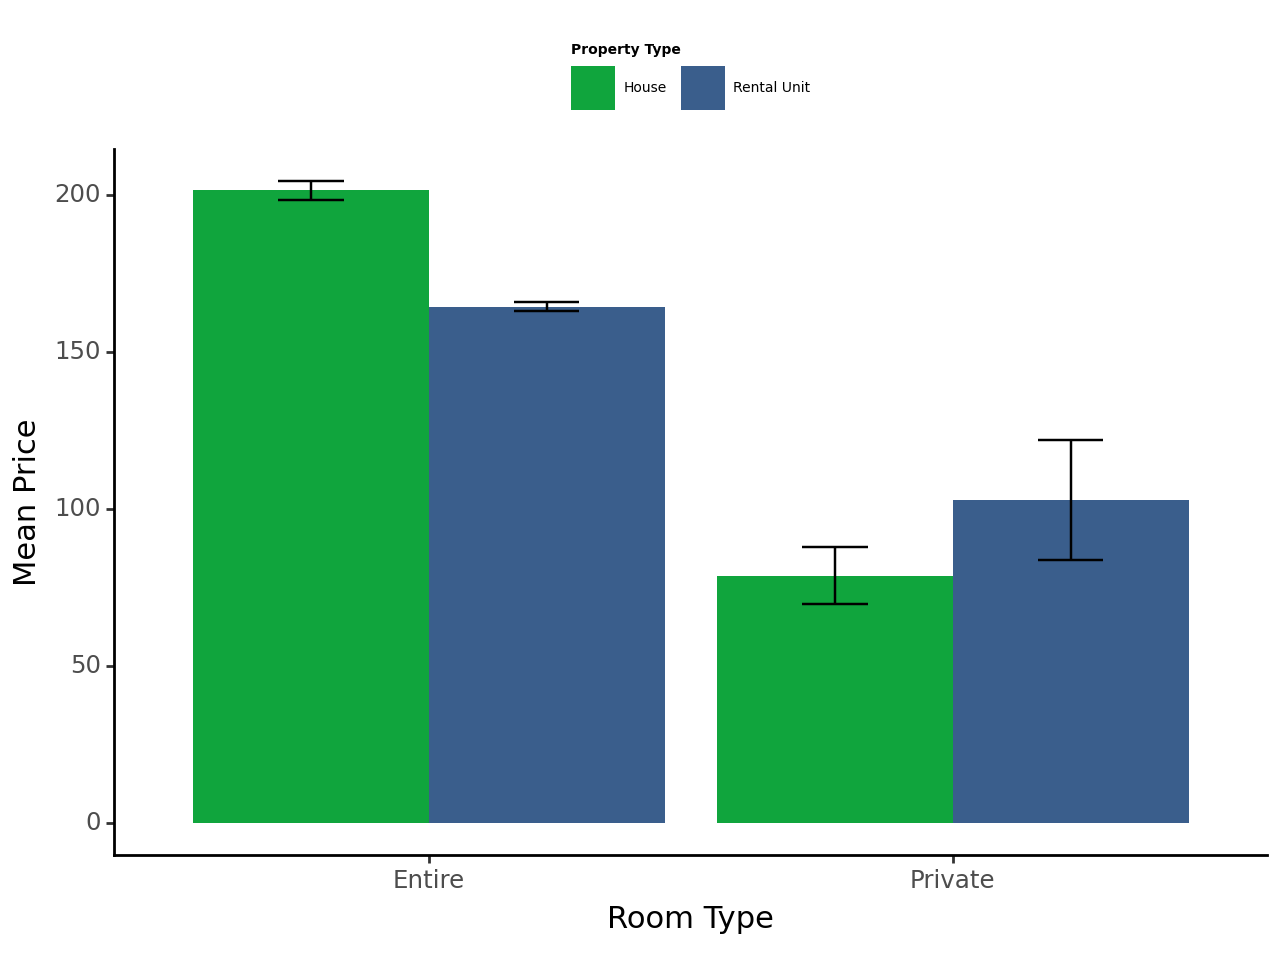

<Figure Size: (640 x 480)>

In [531]:
price_diff_by_variables(
    listings,
    "room_type",
    "property_type",
    "Room Type",
    "Property Type",
)

# OLS Model: Regression with Cross-Validation

In [532]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse

In [533]:
X1 = "room_type:property_type"
modellev1 = "~ accommodates"
modellev2 = "~" + "+".join(basic_lev)
modellev3 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add)
modellev4 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)
modellev5 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1
modellev6 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1+ "+" + "+".join(amenity_columns)

In [534]:
n_folds=5

# Set the seed to make results reproducable
np.random.seed(20240206)
k = KFold(n_splits=n_folds, shuffle=False, random_state=None)


In [535]:
def cv_reg(formula, data, kfold, testdata, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [data_train["price"], model.predict(data_train)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [data_test["price"], model.predict(data_test)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["price"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["price"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [536]:
cv_list = []
for i in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
]:
    cv_list += [cv_reg("price" + i, listings, k, "HC0")]

ols_cv = summarize_cv(cv_list)
ols_cv

,Model1,Model2,Model3,Model4,Model5,Model6
Fold1,64.724506,62.929851,58.997574,58.220181,57.772395,55.422377
Fold2,65.157113,63.396073,59.382009,58.594881,58.220839,56.037391
Fold3,65.110435,63.539551,59.235339,58.608693,58.172658,56.091542
Fold4,64.189302,62.471402,58.108614,57.653052,57.165957,55.100726
Fold5,66.092891,64.475680,60.061073,59.126073,58.443217,56.052595
Average,65.054850,63.362511,59.156922,58.440576,57.955013,55.740926


In [537]:
# RMSE training vs test graph

rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 6):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 6):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
rmse_levels = pd.DataFrame.from_dict(rmse_levels)
rmse_levels["nvars2"] = rmse_levels["nvars"] + 1

In [538]:
rmse_levels

,nvars,var,value,nvars2
0,1,RMSE Training,65.054850,2
1,6,RMSE Training,63.362511,7
2,42,RMSE Training,59.156922,43
3,46,RMSE Training,58.440576,47
4,56,RMSE Training,57.955013,57
5,122,RMSE Training,55.740926,123
6,1,RMSE Test,65.505555,2
7,6,RMSE Test,63.914595,7
8,42,RMSE Test,60.136494,43
9,46,RMSE Test,59.895583,47


In [539]:
# best one:
rmse_levels[rmse_levels['var'] == 'RMSE Test'].min(axis=0)["value"]

58.132331340414126

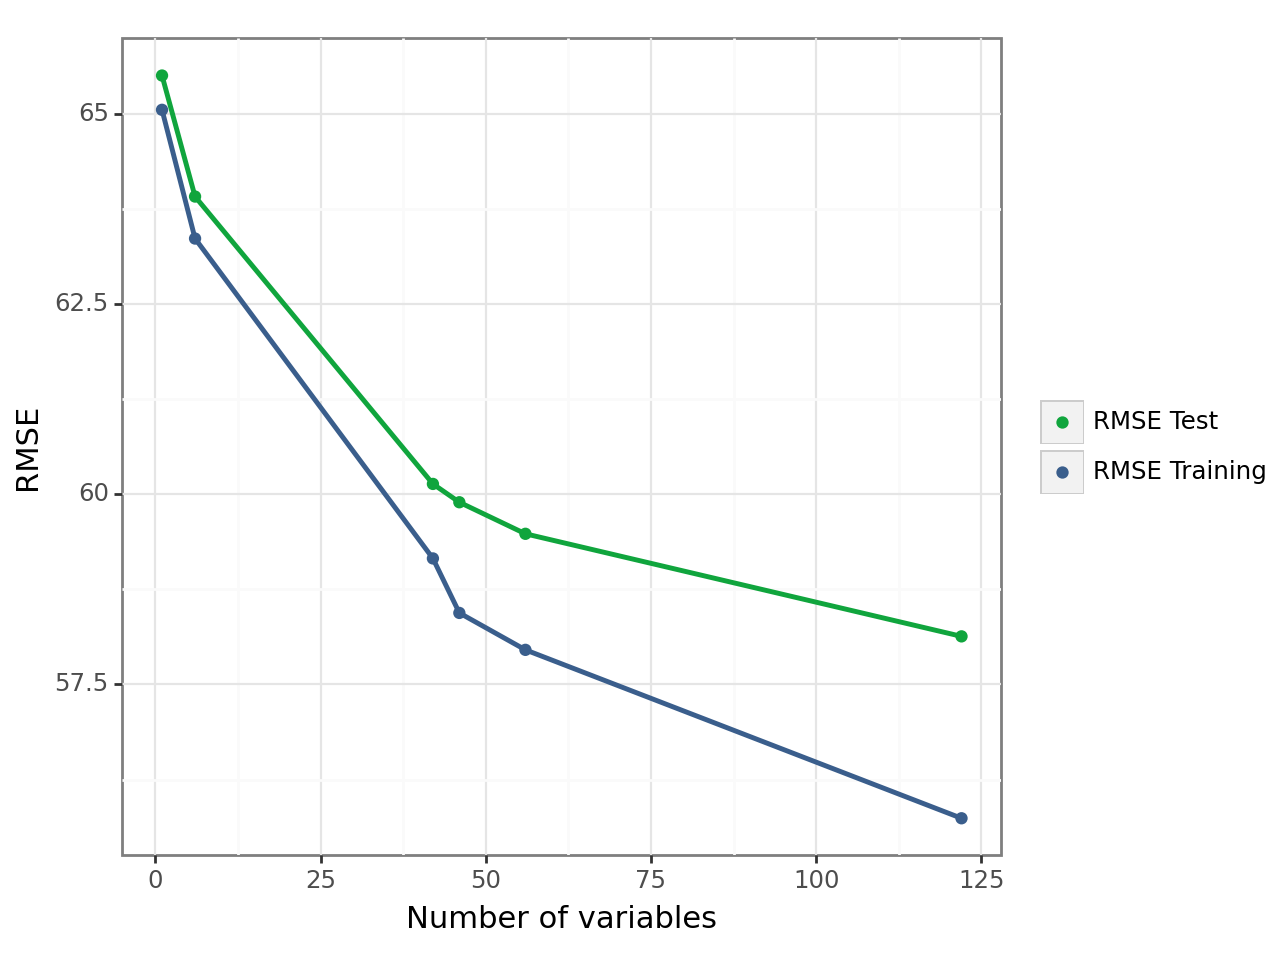

<Figure Size: (640 x 480)>

In [540]:
ols_graph =  (
    ggplot(rmse_levels, aes(x="nvars", y="value", color="var"))
    + geom_point()
    + geom_line(size=1, show_legend=False, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_y_continuous(name="RMSE")
    + labs(x="Number of variables")
    + theme_bw()
    + theme(subplots_adjust={"wspace": 0.25},legend_title=element_blank())
)
ols_graph

# Random FOREST

In [541]:
data_train, data_holdout = train_test_split( listings, train_size=0.8, random_state=42)

In [542]:
data_train.shape, data_holdout.shape

((9060, 116), (2265, 116))

In [543]:
basic_lev = (
    "accommodates",
    "beds",
    "flag_beds",
    "property_type",
    "room_type",
    "bedrooms")

basic_add = ("bathrooms",
             "flag_bathrooms",
             "neighbourhood_cleansed",
             "availability_365",
             "minimum_nights")

reviews = ("number_of_reviews",
           "flag_number_of_reviews",
           "reviews_per_month",
           "flag_reviews_per_month",
           "review_scores_rating",
           "flag_review_scores_rating")

more_reviews = ("review_scores_cleanliness",
                "flag_review_scores_cleanliness",
                "review_scores_checkin",
                "flag_review_scores_checkin",
                "review_scores_communication",
                "flag_review_scores_communication",
                "review_scores_location",
                "flag_review_scores_location",
                "review_scores_value",
                "flag_review_scores_value")

amenity_columns = tuple([col for col in listings.columns if col.startswith("d_")])

In [544]:
predictors_1 = basic_lev
predictors_2 = basic_lev + basic_add
predictors_3 = basic_lev + basic_add + reviews
predictors_4 = basic_lev + basic_add + reviews + more_reviews
predictors_5 = basic_lev + basic_add + reviews + more_reviews + amenity_columns

In [545]:
y, X = dmatrices("price ~ " + " + ".join(predictors_5), data_train)

In [546]:
import math
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 11.53.


In [547]:
y.ravel().shape

(9060,)

In [548]:
rfr = RandomForestRegressor(random_state = 20240129)

In [549]:
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

In [550]:
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [551]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-56.043 total time=   0.7s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-57.540 total time=   0.6s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-57.098 total time=   0.6s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-57.703 total time=   0.6s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-57.818 total time=   0.6s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-57.178 total time=   0.5s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-58.207 total time=   0.5s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-57.912 total time=   0.5s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-58.943 total time=   0.5s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-58.777 total time=   0.5s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-57.879 total time=   0.4s
[CV 2/5] END max_features=6, min_samples_leaf=15;, score=-59.075 total time=   0.

In [552]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-57.240357
1,6,10,-58.203565
2,6,15,-58.846749
3,8,5,-56.340909
4,8,10,-57.319056
5,8,15,-57.881289
6,10,5,-56.051924
7,10,10,-56.945950
8,10,15,-57.479504
9,12,5,-55.686559


In [553]:
forest_df =  df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

forest_df

min node size,5,10,15
max features,,,
6,57.24,58.20,58.85
8,56.34,57.32,57.88
10,56.05,56.95,57.48
12,55.69,56.45,57.10


In [554]:
# best model is 12 max features and 5 min node size
print(rf_model.best_params_)
print(rf_model.best_score_*-1)

{'max_features': 12, 'min_samples_leaf': 5}
55.686558693787184


In [555]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [556]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,bedrooms,8.6%,8.6%
1,accommodates,8.4%,17.0%
2,bathrooms[T.2],6.7%,23.7%
3,bathrooms[T.1],6.1%,29.8%
4,beds,6.1%,35.9%
5,reviews_per_month,4.2%,40.2%
6,availability_365[T.3],3.3%,43.5%
7,review_scores_rating,2.9%,46.4%
8,review_scores_cleanliness,2.5%,49.0%
9,review_scores_location,2.3%,51.3%


# GBM Model

In [557]:
basic_lev = [
    "accommodates",
    "beds",
    "flag_beds",
    "property_type",
    "room_type",
    "bedrooms"]

basic_add = ["bathrooms",
             "flag_bathrooms",
             "neighbourhood_cleansed",
             "availability_365",
             "minimum_nights"]

reviews = ["number_of_reviews",
           "flag_number_of_reviews",
           "reviews_per_month",
           "flag_reviews_per_month",
           "review_scores_rating",
           "flag_review_scores_rating"]

more_reviews = ["review_scores_cleanliness",
                "flag_review_scores_cleanliness",
                "review_scores_checkin",
                "flag_review_scores_checkin",
                "review_scores_communication",
                "flag_review_scores_communication",
                "review_scores_location",
                "flag_review_scores_location",
                "review_scores_value",
                "flag_review_scores_value"]

amenity_columns = [col for col in listings.columns if col.startswith("d_")]


In [558]:
predictors_5 = basic_lev + basic_add + reviews + more_reviews + amenity_columns

In [559]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10
                                #, n_estimators = 50
                               )

tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [560]:
categorical_columns = [col for col in predictors_5 if col in ["property_type", "room_type", "neighbourhood_cleansed"]]
numerical_columns = [col for col in predictors_5 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [561]:
%%time
gbm_pipe.fit(data_train[predictors_5],data_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   8.9s
CPU times: total: 1.69 s
Wall time: 8.9 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type', 'room_type',
                                                   'neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['accommodates', 'beds',
                                                   'flag_beds', 'bedrooms',
                                                   'bathrooms',
                                                   'flag_bathrooms',
                                                   'availability_365',
                                                   'minimum_nights',
                                                   'number_of_reviews',
                                                   'flag_number_of_reviews',
                                                   'reviews_...
                                                   'flag_review_scores_value',
                                                   'd_freeparking', 'd_',
                                                   'd_airconditioning',
                                                   'd_kitchen_equipment',
                                                   'd_alarm', 'd_microwave', ...])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [562]:
gbm_model_cv.cv_results_

{'mean_fit_time': array([1.95537124, 2.72805781, 3.06046491, 3.80879059]),
 'std_fit_time': array([0.23809976, 0.13947582, 0.11788528, 0.08494438]),
 'mean_score_time': array([0.0162394 , 0.01848202, 0.02087212, 0.02578363]),
 'std_score_time': array([0.00288748, 0.00221478, 0.00223913, 0.00101419]),
 'param_max_depth': masked_array(data=[5, 5, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 300, 200, 300],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5, 'n_estimators': 200},
  {'max_depth': 5, 'n_estimators': 300},
  {'max_depth': 10, 'n_estimators': 200},
  {'max_depth': 10, 'n_estimators': 300}],
 'split0_test_score': array([-52.03573451, -51.83539788, -51.85072488, -52.30958875]),
 'split1_test_score': array([-52.85208235, -52.53540734, -52.72537583, -52.23217462]),
 'split2_test_score': array(

In [563]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=5, max_features=10, min_samples_split=20,
                          n_estimators=300)

In [564]:
gbm_rmse = gbm_model_cv.best_score_*-1
gbm_rmse

52.72913858037073

# Comparing Results

In [565]:
results_df = pd.DataFrame({"Model":
                           ["Lasso OLS","OLS CV","Random Forest","Gradient Boosting Model"],
                            "RMSE":
                            [results.best_score_ * -1,rmse_levels[rmse_levels['var'] == 'RMSE Test'].min(axis=0)["value"],rf_model.best_score_*-1,gbm_rmse]
                            })
comparing_results = results_df.sort_values(by="RMSE").reset_index(drop=True)
comparing_results

,Model,RMSE
0,Gradient Boosting Model,52.729139
1,Random Forest,55.686559
2,Lasso OLS,56.701704
3,OLS CV,58.132331
